In [23]:
# abpc_dashboard.py
# Modular, fast dashboard for MoRF/LeRF + metrics table (reads metrics from run.summary).

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple, Optional

class ABPCDashboard:
    """
    Build a 2x2 matplotlib dashboard of MoRF/LeRF mean±std curves and a summary table
    (ABPC, AOPC, norm_ABPC, norm_AOPC); grouped by `aggregation_function`,
    filtered by group ('ABPC') and supervoxel type.

    x-axis modes:
      - 'absolute': truncate each subgroup to its common MIN length across runs
      - 'percent' : resample each run to the subgroup's MAX length (or a fixed N points)

    NOTE: This version DOES NOT recompute metrics. It reads:
      - ABPC_area, AOPC, norm_ABPC, norm_AOPC from run.summary (if present).
    """

    # Colors (MoRF blue, LeRF red, purple gap)
    MORF_COLOR = "#1f77b4"
    LERF_COLOR = "#d62728"
    GAP_COLOR  = "purple"
    BAND_ALPHA = 0.18
    GAP_ALPHA  = 0.12

    def __init__(
        self,
        entity: str = "giuliosichili",
        project: str = "automi",
        group: str = "ABPC",
        subgroups: Optional[List[str]] = None,
        morf_key: str = "MoRF",
        lerf_key: str = "LeRF",
        abpc_key: str = "ABPC_area",
        aopc_key: str = "AOPC",
        norm_abpc_key: str = "norm_ABPC",
        norm_aopc_key: str = "norm_AOPC",
        page_size: int = 256,
    ):
        self.entity = entity
        self.project = project
        self.group = group
        self.subgroups = subgroups or [
            "true_positive_aggregation",
            "false_positive_aggregation",
            "dice_aggregation",
            "logit_difference_aggregation",
        ]
        # prefer the new x; fall back to older name or _step if missing
        self.X_KEY = "supervoxels_perturbed"
        self.X_FALLBACKS = ("_step",)  # optional, keep if you used it before

        # Preferred (signed) keys first, then fall back
        self.SIGNED_MORF_KEY = "signed_MoRF"
        self.SIGNED_LERF_KEY = "signed_LeRF"
        self.MORF_KEY = morf_key
        self.LERF_KEY = lerf_key

        self.ABPC_KEY = abpc_key
        self.AOPC_KEY = aopc_key
        self.NORM_ABPC_KEY = norm_abpc_key
        self.NORM_AOPC_KEY = norm_aopc_key
        self.PAGE_SIZE = page_size
        self._api = wandb.Api()

    # ---------- Public API ----------

    def run(
        self,
        supervoxel_type: str,
        x_mode: str = "absolute",
        percent_points: Optional[int] = None,
        save: bool = True,
        dpi: int = 300,
    ):
        runs = self._fetch_runs(supervoxel_type)
        grouped = self._collect_curves_and_metrics(runs, x_mode=x_mode, percent_points=percent_points)
        fig = self._plot(grouped, supervoxel_type, x_mode)

        if save:
            safe_sv = supervoxel_type.replace(" ", "_")
            fname = f"abpc_dashboard_{x_mode}_{safe_sv}.png"
            fig.savefig(fname, dpi=dpi, bbox_inches="tight")
            print(f"[saved] {fname}")

        plt.show()

    # ---------- Internals ----------

    def _fetch_runs(self, supervoxel_type: str) -> List[wandb.apis.public.Run]:
        path = f"{self.entity}/{self.project}"
        filt = {
            "config.group": {"$eq": self.group},
            "config.supervoxel_type": {"$eq": supervoxel_type},
            "config.aggregation_function": {"$in": self.subgroups},
        }
        return list(self._api.runs(path, filters=filt))

    @staticmethod
    def _resample_to_length(y: np.ndarray, L_target: int) -> np.ndarray:
        L_run = len(y)
        if L_run <= 0:
            return np.zeros(L_target, dtype=float)
        if L_run == 1:
            return np.full(L_target, float(y[0]), dtype=float)
        x_src = np.linspace(0.0, 1.0, L_run)
        x_tgt = np.linspace(0.0, 1.0, L_target)
        return np.interp(x_tgt, x_src, y)

    def _collect_curves_and_metrics(
        self,
        runs: List[wandb.apis.public.Run],
        x_mode: str,
        percent_points: Optional[int],
    ) -> Dict[str, Dict]:
        assert x_mode in {"absolute", "percent"}

        curves_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in self.subgroups}
        lengths: Dict[str, List[int]] = {sg: [] for sg in self.subgroups}
        xgrids_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in self.subgroups}

        abpc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        aopc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        n_abpc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}
        n_aopc_vals: Dict[str, List[float]] = {sg: [] for sg in self.subgroups}

        for r in runs:
            sg = (r.config or {}).get("aggregation_function")
            if sg not in curves_raw:
                continue

            # read metrics from summary
            summ = r.summary or {}
            def _get_float(k):
                v = summ.get(k)
                try:
                    return float(v) if v is not None else None
                except Exception:
                    return None

            abpc = _get_float(self.ABPC_KEY)
            aopc = _get_float(self.AOPC_KEY)
            n_abpc = _get_float(self.NORM_ABPC_KEY)
            n_aopc = _get_float(self.NORM_AOPC_KEY)

            if abpc is not None:   abpc_vals[sg].append(abpc)
            if aopc is not None:   aopc_vals[sg].append(aopc)
            if n_abpc is not None: n_abpc_vals[sg].append(n_abpc)
            if n_aopc is not None: n_aopc_vals[sg].append(n_aopc)

            # gather curves, preferring signed_* keys row-by-row
            morf_vals, lerf_vals = {}, {}

            for row in r.scan_history(page_size=self.PAGE_SIZE):
                # choose x value
                x = row.get(self.X_KEY, None)
                if x is None:
                    for fb in self.X_FALLBACKS:
                        x = row.get(fb, None)
                        if x is not None:
                            break
                if x is None:
                    x = row.get("_step", row.get("step"))
                try:
                    x = int(x)
                except Exception:
                    try:
                        x = int(float(x))
                    except Exception:
                        continue

                # prefer corrected/signed keys; fall back to original
                m = row.get(self.SIGNED_MORF_KEY, row.get(self.MORF_KEY))
                l = row.get(self.SIGNED_LERF_KEY, row.get(self.LERF_KEY))

                if m is not None:
                    try: morf_vals[x] = float(m)
                    except Exception: pass
                if l is not None:
                    try: lerf_vals[x] = float(l)
                    except Exception: pass

            common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
            xgrids_raw[sg].append(np.array(common, dtype=int))
            if len(common) >= 1:
                morf_seq = np.array([morf_vals[s] for s in common], dtype=float)
                lerf_seq = np.array([lerf_vals[s] for s in common], dtype=float)
                seq = np.stack([morf_seq, lerf_seq], axis=1)  # (L_run, 2)
                curves_raw[sg].append(seq)
                lengths[sg].append(len(common))

        grouped: Dict[str, Dict] = {
            sg: {
                "curves": np.empty((0, 2, 2), dtype=float),
                "x": None,
                "abpc_values": abpc_vals[sg],
                "aopc_values": aopc_vals[sg],
                "norm_abpc_values": n_abpc_vals[sg],
                "norm_aopc_values": n_aopc_vals[sg],
            }
            for sg in self.subgroups
        }

        for sg in self.subgroups:
            seqs = curves_raw[sg]
            if not seqs:
                continue

            if x_mode == "absolute":
                L = min(lengths[sg])
                seqs_trunc = [seq[:L] for seq in seqs]
                grouped[sg]["curves"] = np.stack(seqs_trunc, axis=0)
                # choose an x grid to display; median across runs is a good, stable choice
                xs_trunc = np.stack([xs[:L] for xs in xgrids_raw[sg]], axis=0)  # (n, L)
                grouped[sg]["x"] = np.median(xs_trunc, axis=0)  # float; cast to int in plot if you prefer
            else:
                L_target = percent_points if (percent_points and percent_points > 1) else max(lengths[sg])
                resampled = []
                for seq in seqs:
                    morf_rs = self._resample_to_length(seq[:, 0], L_target)
                    lerf_rs = self._resample_to_length(seq[:, 1], L_target)
                    resampled.append(np.stack([morf_rs, lerf_rs], axis=1))
                grouped[sg]["curves"] = np.stack(resampled, axis=0)
                grouped[sg]["x"] = np.linspace(0, 100, L_target)  # percent axis

        return grouped

    @staticmethod
    def _summarize_curves(curves: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        if curves.size == 0:
            return (np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0))
        morf = curves[:, :, 0]
        lerf = curves[:, :, 1]
        morf_mean = morf.mean(axis=0)
        lerf_mean = lerf.mean(axis=0)
        morf_std  = morf.std(axis=0, ddof=1) if morf.shape[0] > 1 else np.zeros_like(morf_mean)
        lerf_std  = lerf.std(axis=0, ddof=1) if lerf.shape[0] > 1 else np.zeros_like(lerf_mean)
        return morf_mean, morf_std, lerf_mean, lerf_std

    @staticmethod
    def _fmt_cell(mu: float, sd: float, normalized: bool = False) -> str:
        if mu is None or (isinstance(mu, float) and np.isnan(mu)):
            return "–"
        if normalized:
            if sd is None or (isinstance(sd, float) and np.isnan(sd)):
                return f"{mu:.4f}"
            return f"{mu:.4f} ± {sd:.4f}"
        else:
            if sd is None or (isinstance(sd, float) and np.isnan(sd)):
                return f"{mu:.3e}"
            return f"{mu:.3e} ± {sd:.1e}"

    def _plot(self, grouped: Dict[str, Dict], supervoxel_type: str, x_mode: str):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10.5), sharex=False, sharey=False)
        axes = axes.ravel()

        titles = {
            "true_positive_aggregation": "True Positive Aggregation",
            "false_positive_aggregation": "False Positive Aggregation",
            "dice_aggregation": "Dice Aggregation",
            "logit_difference_aggregation": "Logit Difference Aggregation",
        }

        for ax, sg in zip(axes, self.subgroups):
            curves = grouped[sg]["curves"]
            if curves.size == 0:
                ax.set_title(titles.get(sg, sg) + " (no data)")
                ax.grid(True, alpha=0.25)
                continue

            L = curves.shape[1]
            x_vals = grouped[sg].get("x", None)
            if x_vals is None:
                # fallback (shouldn’t occur if step 3 is applied)
                L = curves.shape[1]
                x_vals = np.arange(L)

            if x_mode == "percent":
                x_label = "Percent of supervoxels removed"
            else:
                x_label = "Supervoxels removed"

            morf_mean, morf_std, lerf_mean, lerf_std = self._summarize_curves(curves)

            ax.fill_between(x_vals, morf_mean - morf_std, morf_mean + morf_std,
                            color=self.MORF_COLOR, alpha=self.BAND_ALPHA)
            ax.fill_between(x_vals, lerf_mean - lerf_std, lerf_mean + lerf_std,
                            color=self.LERF_COLOR, alpha=self.BAND_ALPHA)

            ax.plot(x_vals, morf_mean, linewidth=2.0, color=self.MORF_COLOR, label="MoRF (mean)")
            ax.plot(x_vals, lerf_mean, linewidth=2.0, color=self.LERF_COLOR, label="LeRF (mean)")

            gap_low  = np.minimum(morf_mean, lerf_mean)
            gap_high = np.maximum(morf_mean, lerf_mean)
            ax.fill_between(x_vals, gap_low, gap_high, color=self.GAP_COLOR, alpha=self.GAP_ALPHA)

            ax.set_title(titles.get(sg, sg))
            ax.grid(True, alpha=0.25)
            ax.set_xlabel(x_label)
            ax.set_ylabel("Score")

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.02))

        title_mode = "% steps" if x_mode == "percent" else "absolute steps"
        fig.suptitle(f"ABPC — MoRF/LeRF (Mean ± Std, {title_mode}) by Aggregation Function — SV: {supervoxel_type}",
                     y=0.98, fontsize=14)

        row_labels = [titles.get(sg, sg) for sg in self.subgroups]
        col_labels = ["ABPC", "AOPC", "norm_ABPC", "norm_AOPC"]
        cell_text = []

        for sg in self.subgroups:
            def _mean_std(vals: List[float]):
                if not vals:
                    return (np.nan, np.nan)
                arr = np.array(vals, dtype=float)
                mu = np.nanmean(arr)
                sd = np.nanstd(arr, ddof=1) if arr.size > 1 else np.nan
                return (mu, sd)

            mu_abpc, sd_abpc   = _mean_std(grouped[sg]["abpc_values"])
            mu_aopc, sd_aopc   = _mean_std(grouped[sg]["aopc_values"])
            mu_nabp, sd_nabp   = _mean_std(grouped[sg]["norm_abpc_values"])
            mu_naop, sd_naop   = _mean_std(grouped[sg]["norm_aopc_values"])

            row = [
                self._fmt_cell(mu_abpc, sd_abpc, normalized=False),
                self._fmt_cell(mu_aopc, sd_aopc, normalized=False),
                self._fmt_cell(mu_nabp, sd_nabp, normalized=True),
                self._fmt_cell(mu_naop, sd_naop, normalized=True),
            ]
            cell_text.append(row)

        table_ax = fig.add_axes([0.05, 0.02, 0.90, 0.18])
        table_ax.axis('off')
        tbl = table_ax.table(
            cellText=cell_text,
            rowLabels=row_labels,
            colLabels=col_labels,
            cellLoc='center',
            loc='center'
        )
        tbl.scale(1.0, 1.2)
        for (row, col), cell in tbl.get_celld().items():
            if row == 0:
                cell.set_text_props(weight='bold')

        fig.tight_layout(rect=[0.02, 0.22, 0.98, 0.92])
        return fig

In [24]:
dash = ABPCDashboard(entity="giuliosichili", project="automi", group="ABPC-volumes")

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_62865/2610499141.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.02, 0.22, 0.98, 0.92])


[saved] abpc_dashboard_absolute_full-organs.png


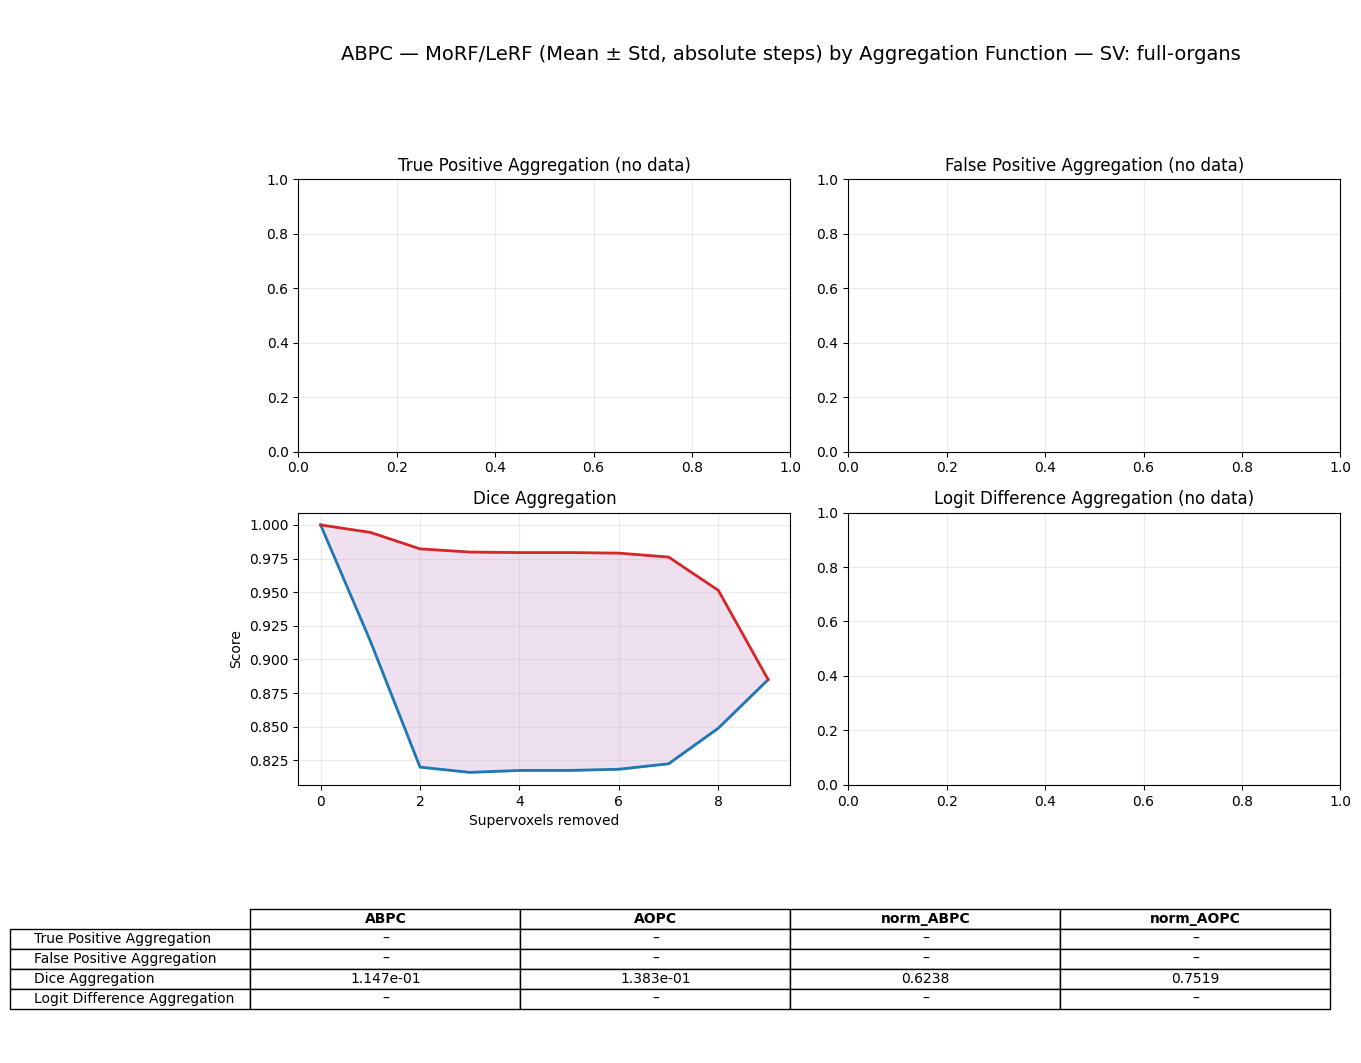

In [25]:

dash.run(supervoxel_type="full-organs", x_mode="absolute")         # truncate to min length

## Save some observations about starting and ending points!

* the two curves start and end in the same point (all on and all off respectively)
* FP aggr. starts on 0, as there can't be spurious predictions for the original input with respect to itself
* Dice Aggregation starts on 1, because the baseline volume produces perfect overlapping with itself.
* TP and Logit Difference start on the same point, here 0.0059 approximately. This is because for the unperturbed volume, all the logits are in the baseline segmentation mask, so their sum is equal to the sum returned by True Positive mask.

these observation are maybe of limited interest, but they strengthen the reliability of these new defined metrics as the behavior is the one expected

## Other observations
* TP plot is very regular, in the sense that LeRF and MoRF curves are mostly simmetric around a point between them. This suggests that this notion of importance, given by preservation of predicted regions, is the most natural from a perspective that considers additivity of the parts (organs in this case) important, and also imply little feature interactions since attribution order is well respected in these plots.
* FP range, which is scaled equally to TP and Logit Difference and it's a logit sum like them, so it's comparable as unit, is very low compared to them. This shows limited spurious lymph nodes predictions, at least not close to baseline segmentation mask mass.
* Dice and LogDiff show a similar shape, and it's expected since the second is a continuous version of the first. We notice a decreasing monotonic behavior in LeRF curve, while the MoRF shows a decreasing and then increasing plot in the least important organs.


/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_62865/2610499141.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.02, 0.22, 0.98, 0.92])


[saved] abpc_dashboard_percent_FCC-organs.png


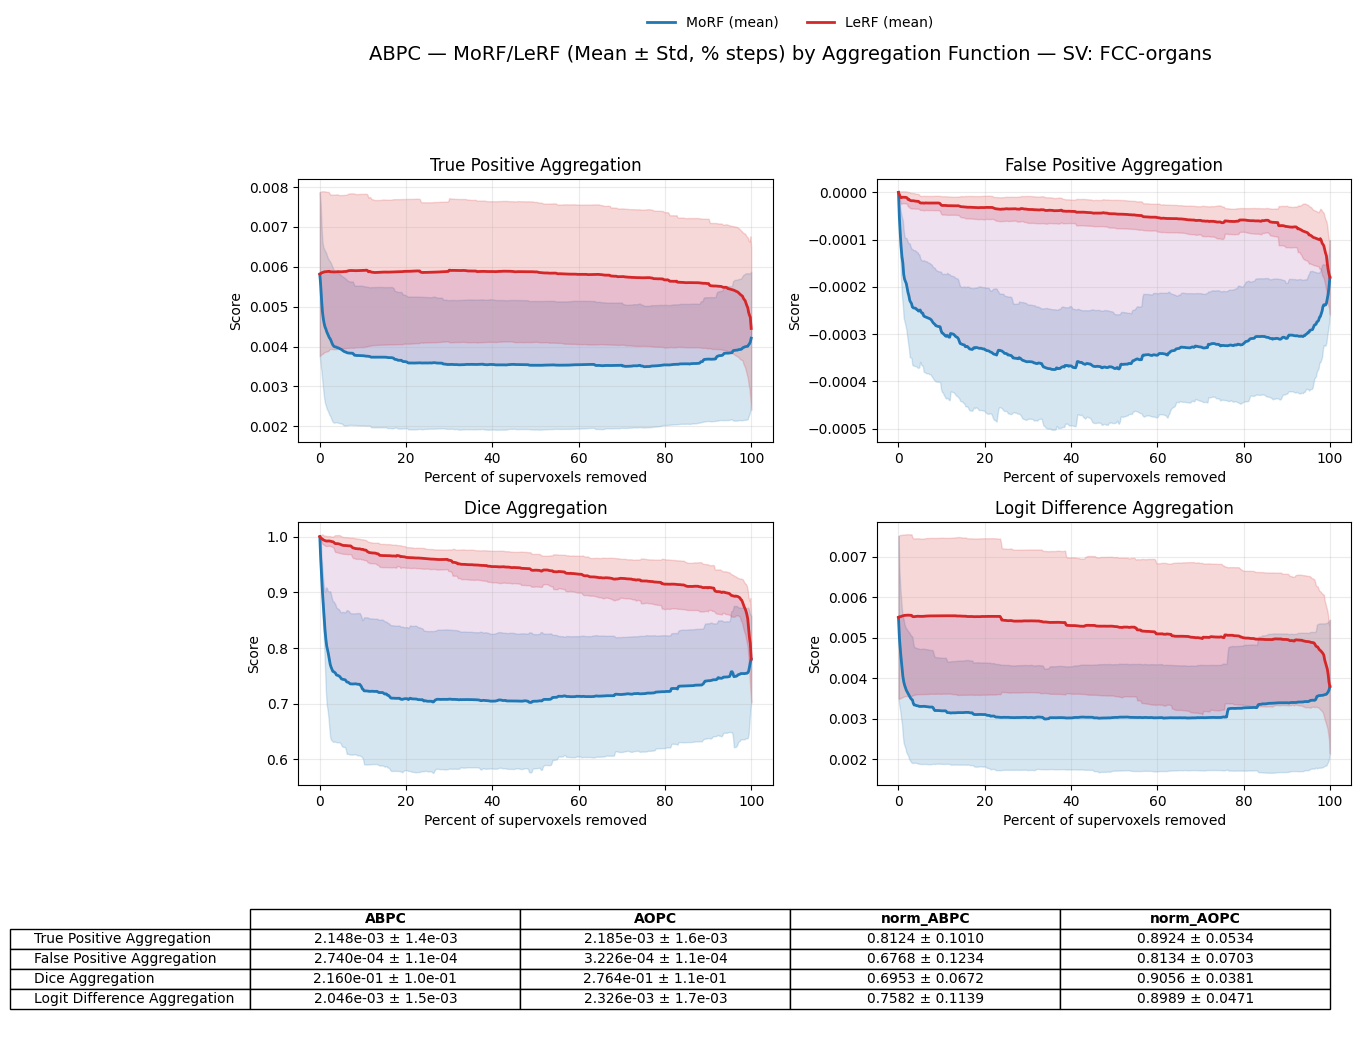

In [26]:
dash.run(supervoxel_type="FCC-organs", x_mode="percent")           # interpolate to subgroup max

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_62865/2610499141.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.02, 0.22, 0.98, 0.92])


[saved] abpc_dashboard_percent_FCC.png


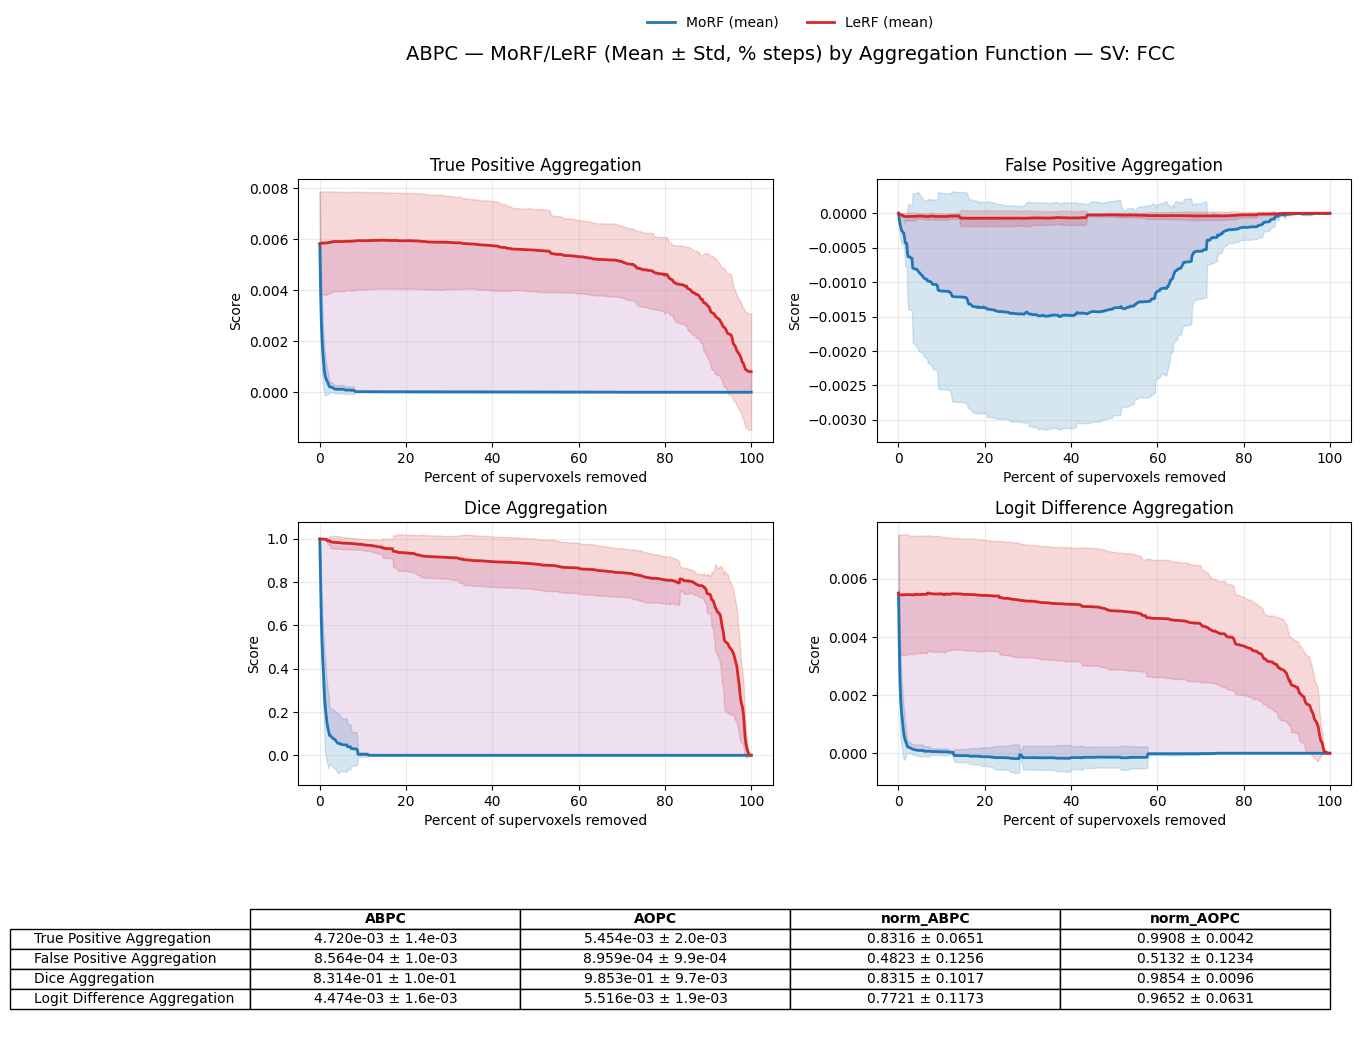

In [27]:
dash.run(supervoxel_type="FCC", x_mode="percent")